<a href="https://colab.research.google.com/github/variable-jain/Deep-learning-experiments-with-pytorch-and-fastai/blob/main/SGD_in_fastai_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Training a Digit Recognizer

> We will attempt to train a digit classifier from absolutely and completely scratch and in the meantime using both a non-ML and ML based approach for the task. We will slowly build up to using Pytorch and then fastai for the same task

In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 21.1MB/s 
     |████████████████████████████████| 194kB 58.9MB/s 
     |████████████████████████████████| 51kB 8.9MB/s 
     |████████████████████████████████| 1.2MB 41.5MB/s 
     |████████████████████████████████| 61kB 10.6MB/s 
Mounted at /content/gdrive


In [3]:
from fastai.vision.all import *
from fastbook import *
matplotlib.rc('image', cmap='Greys')

## Preparing Data

> We are using a little function from fastai to grab the dataset

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)

In [5]:
Path.BASE_PATH = path

In [6]:
path.ls()

(#3) [Path('labels.csv'),Path('train'),Path('valid')]

In [7]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

In [8]:
threes = (path/'train/3').ls().sorted()
sevens = (path/'train/7').ls().sorted()
len(threes), len(sevens)

(6131, 6265)

In [9]:
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

## Our baseline Non-ML model
> We are using a very naive approach - **Pixel similarity**, which works in case of 3s and 7s on account of how different they are

In [10]:
three_tensors = [tensor(Image.open(o)) for o in threes]
seven_tensors = [tensor(Image.open(o)) for o in sevens]

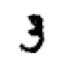

In [11]:
show_image(three_tensors[0])

In [12]:
stacked_threes = torch.stack(three_tensors).float()/255.
stacked_sevens = torch.stack(seven_tensors).float()/255.

In [13]:
stacked_sevens.shape

torch.Size([6265, 28, 28])

In [14]:
stacked_threes.shape

torch.Size([6131, 28, 28])

We create our ideal 3 and 7 from our dataset by taking the mean pixel value over all threes and sevens

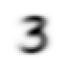

In [15]:
mean_3 = stacked_threes.mean(0)
show_image(mean_3)

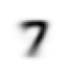

In [16]:
mean_7 = stacked_sevens.mean(0)
show_image(mean_7)

We measure distance from the ideal 3 and 7 as either L1 or L2 norm

In [17]:
valid_3_tensors = torch.stack([tensor(Image.open(o)) for o in (path/'valid/3').ls().sorted()]).float()/255.
valid_7_tensors = torch.stack([tensor(Image.open(o)) for o in (path/'valid/7').ls().sorted()]).float()/255.
valid_3_tensors.shape, valid_7_tensors.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

Here's our loss function

In [18]:
def mnist_distance(x, y): return (x-y).abs().mean((-1,-2))

In [19]:
mnist_distance(stacked_threes[0], mean_3)

tensor(0.1074)

In [20]:
valid_3_dist = mnist_distance(valid_3_tensors, mean_3)
valid_3_dist.shape

torch.Size([1010])

Our classification function judges whether the image looks more like our ideal 3 or ideal 7

In [21]:
def is_3(im): return mnist_distance(im, mean_3) < mnist_distance(im, mean_7)

In [22]:
is_3(valid_3_tensors)

tensor([ True,  True,  True,  ..., False,  True,  True])

In [23]:
accuracy_3 = is_3(valid_3_tensors).float().mean()
accuracy_7 = 1-is_3(valid_7_tensors).float().mean()
accuracy_3, accuracy_7

(tensor(0.9168), tensor(0.9854))

In [24]:
mean_acc = (accuracy_3 + accuracy_7)/2.
mean_acc

tensor(0.9511)

> So we have a pretty good >95% accuracy with a naive non-ML model that uses   pretty much common sense only. Lets move on and use SGD for the problem

## SGD model for MNIST

### Dataset preparation

In [25]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1,28*28)

In [26]:
train_x.shape

torch.Size([12396, 784])

In [27]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_y.shape

torch.Size([12396, 1])

In [28]:
dset = list(zip(train_x, train_y))
x,y = dset[0]
x.shape, y.shape

(torch.Size([784]), torch.Size([1]))

In [29]:
valid_x = torch.cat([valid_3_tensors, valid_7_tensors]).view(-1,28*28)
valid_y = tensor([1]*len(valid_3_tensors) + [0]*len(valid_7_tensors)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

### 7 step process of creating an SGD model

***Step 1: Initialize parameters***

In [30]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [31]:
weights = init_params((28*28,1))

In [32]:
bias = init_params(1)

***Step 2: Calculate predictions***

In [33]:
def linear1(xb): return xb@weights + bias

In [34]:
preds = linear1(train_x)
preds

tensor([[ -6.2330],
        [-10.6388],
        [-20.8865],
        ...,
        [-15.9176],
        [ -1.6866],
        [-11.3568]], grad_fn=<AddBackward0>)

In [35]:
corrects = (preds>0.0).float()==train_y
corrects

tensor([[False],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [ True]])

In [37]:
corrects.float().mean().item()

0.5379961133003235

***Step 3: Calculate loss***

In [41]:
def mnist_loss(preds, targs): 
    preds = preds.sigmoid()
    return torch.where(targs==1, 1-preds, preds).mean()

In [42]:
mnist_loss(preds, train_y)

tensor(0.4624, grad_fn=<MeanBackward0>)

***Step 4: Calculate gradients***

In [43]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

***Step 5: Step the weights***

In [44]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

***Step 6: Repeat the process***

In [45]:
dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)

In [55]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    return ((preds>0.5)==yb).float().mean()

In [47]:
def validation_epoch(model):
    accs = [batch_accuracy(model(xb),yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(),4)

In [56]:
weights = init_params((28*28,1))
bias = init_params(1)
params = weights,bias
lr = 1.
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validation_epoch(linear1), end=' ')

0.6117 0.8256 0.9008 0.9247 0.936 0.9433 0.9492 0.9511 0.955 0.9579 0.9594 0.9614 0.9619 0.9619 0.9633 0.9643 0.9653 0.9658 0.9672 0.9687 

***Step 7: Stop the process***
> We decided to stop this after 20 epochs but we can go on until the accuracy doesn't get better or we start to overfit

### Creating a Pytorch optimizer for performing SGD

In [112]:
linear_model = nn.Linear(28*28,1)

In [113]:
w,b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [114]:
class BasicOptim:
    def __init__(self, params, lr): self.params, self.lr = list(params), lr
        
    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr
    
    def zero_grad(self):
        for p in self.params: p.grad = None

In [115]:
opt = BasicOptim(linear_model.parameters(), lr)

In [116]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb,yb,linear_model)
        opt.step()
        opt.zero_grad()

In [117]:
validation_epoch(linear_model)

0.3726

In [118]:
def train_model(model, epochs):
    for _ in range(epochs):
        train_epoch(model)
        print(validation_epoch(model), end=' ')

In [119]:
train_model(linear_model, 20)

0.4932 0.7119 0.8574 0.9189 0.9355 0.9502 0.9565 0.9638 0.9653 0.9673 0.9697 0.9707 0.9746 0.9751 0.9761 0.9775 0.9775 0.9775 0.9785 0.979 

### Using fastai

In [122]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
dls = DataLoaders(dl, valid_dl)
learn = Learner(dls, linear_model, loss_func=mnist_loss, opt_func=SGD, metrics=batch_accuracy)
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637240,0.503109,0.495584,00:00
1,0.427566,0.271200,0.745339,00:00
2,0.160958,0.155670,0.861629,00:00
3,0.072476,0.097234,0.919038,00:00
4,0.039770,0.073034,0.935231,00:00
5,0.026934,0.059448,0.950932,00:00
6,0.021619,0.050821,0.957802,00:00
7,0.019217,0.044994,0.964181,00:00
8,0.017969,0.040848,0.966143,00:00
9,0.017200,0.037761,0.968106,00:00


> We can also add a non-linearity and an second layer to make our model more deep

In [125]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [126]:
learn = Learner(dls, model=simple_net, loss_func=mnist_loss, opt_func=SGD, metrics=batch_accuracy)

In [127]:
learn.fit(40,0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.297826,0.412711,0.504416,00:00
1,0.141659,0.220021,0.817959,00:00
2,0.078845,0.112063,0.919038,00:00
3,0.052153,0.076439,0.940628,00:00
4,0.039760,0.060024,0.958783,00:00
5,0.033399,0.050752,0.963690,00:00
6,0.029718,0.044880,0.965653,00:00
7,0.027314,0.040841,0.968597,00:00
8,0.025575,0.037894,0.968597,00:00
9,0.024225,0.035641,0.971050,00:00


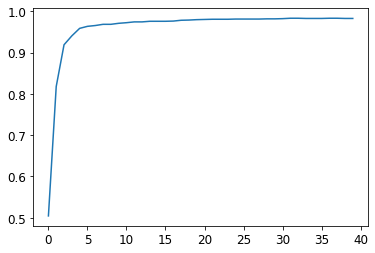

In [128]:
plt.plot(L(learn.recorder.values).itemgot(2))

In [132]:
learn.recorder.values[-1][2]

0.982826292514801

## CNN for full MNIST classifier

In [133]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False, loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1,0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.131742,0.018152,0.997056,00:15
